In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import torch
from stabox.model._utils import Stats_Spatial_Net
from stabox.model import STAligner
import glob
from scipy.sparse import issparse, csr_matrix
from stabox.pl.utils import Cal_Spatial_Net_new
import anndata as ad
import scipy.linalg

/home/lzj/anaconda3/envs/stomics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "/mnt/disk1/LZJ/project/STABox/STABox_Data/Stero-seq"

In [3]:
Batch_list = []
adj_list = []
# section_ids = ['151673','151674','151675','151676']
section_ids = ['E9.5_E1S1', 'E10.5_E1S1']

for section_id in section_ids:
    adata = sc.read(os.path.join(path,f'{section_id}.MOSTA.h5ad'))
    adata.var_names_make_unique(join="++")

    # read the annotation
    # Ann_df = pd.read_csv(os.path.join(path, section_id + '_truth.txt'), sep='\t', header=None, index_col=0)
    # Ann_df.columns = ['Ground Truth']
    # Ann_df[Ann_df.isna()] = "unknown"
    # adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth'].astype('category')
    
    # make spot name unique
    adata.obs_names = [x+'_'+section_id for x in adata.obs_names]
    
    # Constructing the spatial network
    Cal_Spatial_Net_new(adata, rad_cutoff=150) # the spatial network are saved in adata.uns[‘adj’]
    # STAligner.Stats_Spatial_Net(adata) # plot the number of spatial neighbors
    
    # Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

Only considering the two last: ['.MOSTA', '.h5ad'].
Only considering the two last: ['.MOSTA', '.h5ad'].
------Calculating spatial graph...
The graph contains 295650 edges, 5913 cells.
50.0000 neighbors per cell on average.


/home/lzj/anaconda3/envs/stomics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Only considering the two last: ['.MOSTA', '.h5ad'].
Only considering the two last: ['.MOSTA', '.h5ad'].
------Calculating spatial graph...
The graph contains 920400 edges, 18408 cells.
50.0000 neighbors per cell on average.


/home/lzj/anaconda3/envs/stomics/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [4]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=section_ids)
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
adata_concat.uns['edge_list'] = adj_list
print('adata_concat.shape: ', adata_concat.shape)

/home/lzj/anaconda3/envs/stomics/lib/python3.10/site-packages/anndata/_core/merge.py:1287: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_annot[label] = label_col


adata_concat.shape:  (24321, 636)


/tmp/ipykernel_3418164/2816622918.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')


In [5]:
staligner = STAligner(model_dir="D:/Users/lqlu/work/Data/STABox_Data/0X_Data/DLPFC/Multi-Slices", in_features=964, hidden_dims=[512, 30])

In [6]:
staligner.train_minibatch(adata_concat, knn_neigh=100, margin=2.5)

/mnt/disk1/LZJ/project/STABox/STABox/src/stabox/model/staligner.py:301: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_i.uns['edgeList'] = np.nonzero(adj_list[i])
/mnt/disk1/LZJ/project/STABox/STABox/src/stabox/model/staligner.py:301: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_i.uns['edgeList'] = np.nonzero(adj_list[i])


STAGateModule(
  (conv1): GATConv(636, 512, heads=1)
  (conv2): GATConv(512, 30, heads=1)
  (conv3): GATConv(30, 512, heads=1)
  (conv4): GATConv(512, 636, heads=1)
)
Pretrain with STAGATE...[(0, 1)]


100%|██████████| 250/250 [01:07<00:00,  3.68it/s]


Train with STAligner...[(0, 1)]


  0%|          | 0/250 [00:00<?, ?it/s]

Update spot triplets at epoch 0


 40%|████      | 100/250 [00:45<01:02,  2.40it/s]

Update spot triplets at epoch 100


 80%|████████  | 200/250 [01:33<00:18,  2.73it/s]

Update spot triplets at epoch 200


100%|██████████| 250/250 [02:01<00:00,  2.06it/s]


AnnData object with n_obs × n_vars = 24321 × 636
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - Arid3a', 'Regulon - Arx', 'Regulon - Atf4', 'Regulon - Atf6', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Bcl11a', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bmyc', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Chd1', 'Regulon - Clock', 'Regulon - Creb1', 'Regulon - Creb3', 'Regulon - Crem', 'Regulon - Crx', 'Regulon - Ctcf', 'Regulon - Cux1', 'Regulon - Dbx1', 'Regulon - Dbx2', 'Regulon - Dlx4', 'Regulon - Dlx5', 'Regulon - Dlx6', 'Regulon - E2f1', 'Regulon - E2f2', 'Regulon - E2f3', 'Regulon - E2f4', 'Regulon - E2f5', 'Regulon - E2f6', 'Regulon - E2f7', 'Regulon - E2f8', 'Regulon - Ebf1', 'Regulon - Egr2', 'Regulon - Egr4', 'Regulon - Elf1', 'Regulon - Elf2', 'Regulon - Elk1', 'Regulon - Elk3', 'Regulon - Emx2', 'Regulon - En1', 'R

In [7]:
sc.pp.neighbors(adata_concat, use_rep='STAligner', random_state=666)
sc.tl.umap(adata_concat, random_state=666)

In [8]:
louvain_resolution = 0.6
sc.tl.louvain(adata_concat, random_state=666, key_added="louvain", resolution=louvain_resolution)

/home/lzj/anaconda3/envs/stomics/lib/python3.10/site-packages/scanpy/tools/_louvain.py:255: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[key_added] = pd.Categorical(


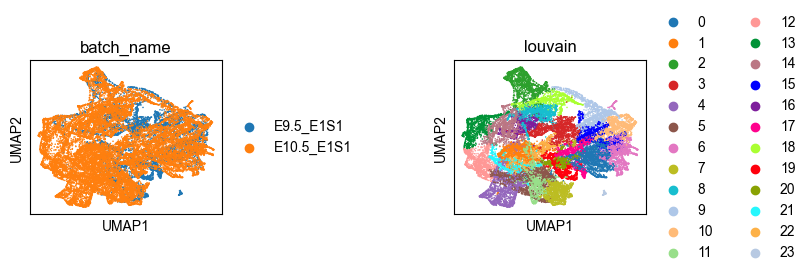

/tmp/ipykernel_3418164/3085505446.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Batch_list[ss].obs['louvain'] = adata_concat[adata_concat.obs['batch_name'] == section_ids[ss]].obs['louvain'].values
/tmp/ipykernel_3418164/3085505446.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Batch_list[ss].obs['louvain'] = adata_concat[adata_concat.obs['batch_name'] == section_ids[ss]].obs['louvain'].values


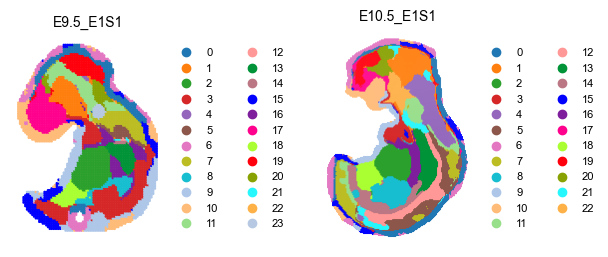

In [9]:
colors_default = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                  '#8c564b', '#e377c2', '#bcbd22', '#17becf', '#aec7e8',
                  '#ffbb78', '#98df8a', '#ff9896', '#009337', '#bb7784',
                  '#0000ff', '#7e1e9c', '#ff028d', '#aaff32', '#ff000d',
                  '#89a203', '#26f7fd', '#fdb147', '#b7c9e2', '#ae7181',
                  '#c7fdb5', '#cd416b', '#001146', '#06470c', '#000000',
                  '#e50000', '#95d0fc', '#89fe05', '#bf77f6', '#00035b',
                  '#d1b26f', '#13eac9', '#06c2ac', '#06470c', '#35063e']

adata_concat.uns['louvain_colors'] = [colors_default[0:][i] for i in np.sort(adata_concat.obs['louvain'].unique().astype('int'))]

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams["figure.figsize"] = (2, 2)
plt.rcParams['font.size'] = 10

sc.pl.umap(adata_concat, color=['batch_name', 'louvain'], ncols=2, wspace=1, show=True)



for ss in range(len(section_ids)):
    Batch_list[ss].obs['louvain'] = adata_concat[adata_concat.obs['batch_name'] == section_ids[ss]].obs['louvain'].values
    Batch_list[ss].uns['louvain_colors'] = [colors_default[0:][i] for i in np.sort(adata_concat[adata_concat.obs['batch_name'] ==
                                                                            section_ids[ss]].obs['louvain'].unique().astype('int'))]

import matplotlib.pyplot as plt
spot_size = 1
title_size = 10
fig, ax = plt.subplots(1, len(section_ids), figsize=(len(section_ids)*3, 3), gridspec_kw={'wspace':1, 'hspace': 0.1})
for ss in range(len(section_ids)-1):
    _sc_0 = sc.pl.spatial(Batch_list[ss], img_key=None, color=['louvain'], title=['louvain'], size=1.5, legend_fontsize=8,
                  show=False, frameon=False, ax=ax[ss], spot_size=spot_size)
    _sc_0[0].set_title(section_ids[ss], size=title_size)
_sc_0 = sc.pl.spatial(Batch_list[-1], img_key=None, color=['louvain'], title=['louvain'], size=1.5, legend_fontsize=8,
              show=False, frameon=False, ax=ax[-1], spot_size=spot_size)
_sc_0[0].set_title(section_ids[-1], size=title_size)
plt.show()